# Welcome to OnSSET Jupyter Interface¶

This page will guide you through the a simplified version of the OnSSET code, as well as the various parameters that can be set to generate any scenario of interest. The code is split up into blocks indicating main steps of the electrification analysis. Thus the blocks shall be executed sequesntially.

Note! Online vizualization does not work if tool runs offline.

### Here you can choose the country of the analysis, as well as the modelling period.

In [8]:
country = 'Malawi'

#Dependencies
from IPython.display import display, Markdown, HTML
import seaborn as sns
import matplotlib.pylab as plt
import folium
import branca.colormap as cm
import json
%matplotlib inline
%run onsset.py

2019-02-25 17:44:16,647		backend module://ipykernel.pylab.backend_inline version unknown


# Step 1 and 2. GIS data collection and processing

GIS data collection and processing is a demanding and time consuming process. The necessary layers should be prepared and calibarated properly for the model to work. In this case pre-made data will be used in a form of .csv files avaialble <a href="https://drive.google.com/drive/folders/0B4H9lfvb9fHKUFNUUHM5UTJ6WW8" target="_blank">here</a>.

You can see an example for the selected country below.

In [9]:
o = SettlementProcessor('{}.csv'.format(country))

display(Markdown('### A random sampling from the input file for {}'.format(country)))
o.df[['Country','X','Y','Pop','GridDistPlan','NightLights','TravelHours','GHI',
    'WindVel','Hydropower','HydropowerDist']].sample(7)

### A random sampling from the input file for Malawi

Country            X            Y           Pop  GridDistPlan  \
1187  Malawi  3770.460355 -1091.749563  31838.648438    227.600149   
1054  Malawi  3724.085719 -1222.917895      0.054188    123.248289   
15    Malawi  3900.309337 -1868.622392    610.160584     32.336386   
77    Malawi  3937.409046 -1801.373479  42662.453125     50.146714   
707   Malawi  3807.560064 -1486.893743   5451.588379      5.880335   
396   Malawi  3807.560064 -1610.304654  15454.870117     26.228366   
967   Malawi  3733.360646 -1288.695754   8270.805664     73.092435   

      NightLights  TravelHours     GHI   WindVel  Hydropower  HydropowerDist  
1187          0.0     1.500000  2185.0  5.805355     120.680        5.685257  
1054          0.0     3.166667  2133.0  4.118885     935.759       22.520510  
15            0.0     1.600000  1966.0  3.978755     110.360       60.399920  
77            0.0     0.883333  1970.0  4.176636    4502.930        4.585369  
707           0.0     2.633333  2097.0  3.971681     101.749       54.872110  
396           0.0     0.800000  2003.0  4.625895     404.855       35.558018  
967           0.0     1.666667  2111.0  4.408803     333.167       24.560598

# Step 3a. Enter country specific data (Social)

These are values that vary per country. They should be changed accordingly to better reflect the selected country's current and expected development.

In [10]:
pop_actual = 17000000
pop_future = 26000000

urban_current = 0.574966829
urban_future = 0.633673829

num_people_per_hh_rural = 4.6
num_people_per_hh_urban = 4.4

# Step 3b. Enter country specific data (Energy Access Target)

In [11]:
energy_per_hh_rural = 50  #  in kWh/household/year (examples are 22, 224, 695, 1800, 2195)
energy_per_hh_urban = 1200

o.condition_df()
o.grid_penalties()
o.calc_wind_cfs()

ignore = o.calibrate_pop_and_urban(pop_actual, pop_future, urban_current, urban_future, 100)

2019-02-25 17:44:27,634		Ensure that columns that are supposed to be numeric are numeric
2019-02-25 17:44:27,641		Replace null values with zero
2019-02-25 17:44:27,642		Sort by country, Y and X
2019-02-25 17:44:27,654		Add columns with location in degrees
2019-02-25 17:44:27,744		Classify road dist
2019-02-25 17:44:27,776		Classify substation dist
2019-02-25 17:44:27,800		Classify land cover
2019-02-25 17:44:27,829		Classify elevation
2019-02-25 17:44:27,859		Classify slope
2019-02-25 17:44:27,887		Combined classification
2019-02-25 17:44:27,909		Grid penalty
2019-02-25 17:44:27,942		Calculate Wind CF
2019-02-25 17:44:28,014		Calibrate current population
2019-02-25 17:44:28,042		Calibrate urban split
2019-02-25 17:44:28,197		NOT SATISFIED: repeating myself
2019-02-25 17:44:28,199		Project future population


# Step 3c. Enter country specific data (Preparation - Calibration)
The cell below contains the procedures to prepare the geospatial data and make it ready to process a scenario. This includes setting grid penalties, calculating wind capacity factors and estimating current population and electricity access a values.

The most important part is to set the actual electricity access rate, and then to adjust the other parameters to let the software which settlements are electrified and which not.

In [12]:
elec_actual = 0.11

Then you should set the parameters that decide whether or not a settlement is grid-connected, and run the block to see what the result is.

### This will need to be repeated until a satisfactory value is reached!

In [13]:
# Set the minimum night light intensity, below which it is assumed there is no electricity access.
min_night_lights = 10

# In addition to the above, one of the below conditions must be reached to consider a settlement eelctrified.
pop_cutoff = 10000
max_grid_dist = 10  # in km
max_road_dist = 5  # in km

o.df[SET_ELEC_CURRENT] = o.df.apply(lambda row: 1
                                if row[SET_NIGHT_LIGHTS] > min_night_lights and
                                    (row[SET_POP_CALIB] > pop_cutoff or
                                    row[SET_GRID_DIST_CURRENT] < max_grid_dist or
                                    row[SET_ROAD_DIST] < max_road_dist) else 0, axis=1)

o.df.loc[o.df[SET_ELEC_CURRENT] == 1, SET_NEW_CONNECTIONS] = o.df[SET_POP_FUTURE] - o.df[SET_POP_CALIB]
o.df.loc[o.df[SET_ELEC_CURRENT] == 0, SET_NEW_CONNECTIONS] = o.df[SET_POP_FUTURE]
o.df.loc[o.df[SET_NEW_CONNECTIONS] < 0, SET_NEW_CONNECTIONS] = 0

elec_modelled = o.df.loc[o.df[SET_ELEC_CURRENT] == 1, SET_POP_CALIB].sum() / pop_actual
display(Markdown('### The modelled electrification rate is {:.2f}, compared to the actual value of {:.2f}. \
                 If this is acceptable, you can continue.'.format(elec_modelled, elec_actual)))
display(Markdown('### A random sampling from the input file for {}, showing some newly calculated columns'
                 .format(country)))
o.df[[SET_X_DEG,SET_Y_DEG, SET_POP_FUTURE, SET_URBAN, SET_ELEC_CURRENT, SET_WINDCF, SET_GRID_PENALTY]].sample(5)

### The modelled electrification rate is 0.09, compared to the actual value of 0.11.                  If this is acceptable, you can continue.

### A random sampling from the input file for Malawi, showing some newly calculated columns

X_deg      Y_deg     PopFuture  IsUrban  ElecStart    WindCF  \
530  33.037441 -13.906892  25876.335387        1          0  0.056590   
370  35.703620 -14.573437  12224.793273        0          0  0.025603   
869  33.953940 -12.407167    701.921439        0          0  0.016889   
544  34.203894 -13.906892   6261.902592        0          0  0.006399   
585  33.620667 -13.740256  47938.198770        1          0  0.054987   

     GridPenalty  
530     1.160987  
370     1.050618  
869     1.053249  
544     1.055995  
585     1.147053

# Step 3d. Enter country specific data (Technology specifications & costs)

The cell below contains all the information that is used to calculate the levelised costs for all the technologies, including grid. These should be updated to reflect the most accurate values.

The following values can be provided by KTH dESA, based on OSeMOSYS, the open source optimization model for long-run integrated assessment and energy planning.

These are the general parameters for calculating LCOE for all technologies:

In [14]:
Technology.set_default_values(start_year=2015,
                              end_year=2030,
                              discount_rate=0.08,
                              grid_cell_area=1,
                              mv_line_cost=9000,
                              lv_line_cost=5000,
                              mv_line_capacity=50,
                              lv_line_capacity=10,
                              lv_line_max_length=30,
                              hv_line_cost=53000,
                              mv_line_max_length=50,
                              hv_lv_transformer_cost=5000,
                              mv_increase_rate=0.1)

These are the technology parameters for extending the grid:

In [15]:
max_grid_extension_dist = 50
grid_price = 0.05

grid_calc = Technology(om_of_td_lines=0.03,
                       distribution_losses=0.1,
                       connection_cost_per_hh=125,
                       base_to_peak_load_ratio=0.5,
                       capacity_factor=1,
                       tech_life=30,
                       grid_capacity_investment=2000,
                       grid_price=grid_price)

These are the technology parameters for the diesel technologies:

In [16]:
diesel_price = 0.5

mg_diesel_calc = Technology(om_of_td_lines=0.03,
                            distribution_losses=0.05,
                            connection_cost_per_hh=100,
                            base_to_peak_load_ratio=0.5,
                            capacity_factor=0.7,
                            tech_life=15,
                            om_costs=0.1,
                            efficiency=0.33,
                            capital_cost=721,
                            diesel_price=diesel_price,
                            diesel_truck_consumption=33.7,
                            diesel_truck_volume=15000)

sa_diesel_calc = Technology(base_to_peak_load_ratio=0.5,
                            capacity_factor=0.7,
                            tech_life=10,
                            om_costs=0.1,
                            capital_cost=938,
                            diesel_price=diesel_price,
                            standalone=True,
                            efficiency=0.28,
                            diesel_truck_consumption=14,
                            diesel_truck_volume=300)

These are the technology parameters for PV:

In [17]:
mg_pv_calc = Technology(om_of_td_lines=0.03,
                        distribution_losses=0.05,
                        connection_cost_per_hh=100,
                        base_to_peak_load_ratio=0.9,
                        tech_life=20,
                        om_costs=0.015,
                        capital_cost=4300)

sa_pv_calc = Technology(base_to_peak_load_ratio=0.9,
                        tech_life=15,
                        om_costs=0.012,
                        capital_cost=5500,
                        standalone=True)

These are the technology parameters for hydro and wind:

In [18]:
mg_hydro_calc = Technology(om_of_td_lines=0.03,
                           distribution_losses=0.05,
                           connection_cost_per_hh=100,
                           base_to_peak_load_ratio=1,
                           capacity_factor=0.5,
                           tech_life=30,
                           capital_cost=5000,
                           om_costs=0.02)

mg_wind_calc = Technology(om_of_td_lines=0.03,
                          distribution_losses=0.05,
                          connection_cost_per_hh=100,
                          base_to_peak_load_ratio=0.75,
                          capital_cost=3000,
                          om_costs=0.02,
                          tech_life=20)

# Step 4. Estimating the LCoE per technology under various demand profiles

Every technology yields a different Levelized Cost for electricity production (LCoE) based on specific characteristics such as the population size and resource availability and/or cost. To illustrate, the cost of providing electricity in a low populated, isolated location (far from grid and roads) will probably be a more demanding (thus expensive) task than a high populated urban settlement. 

Here is an example of how the different technologies perform under the followinga assumptions:
 - Distance from the National Electricity grid: 20 km
 - Global Horizontal Irradiation: 1500 kWh/m2/year
 - Hydro Availability: Positive
 - Diesel price: 0.345 USD/liter
 
 ### Note: this block takes a bit of time

In [19]:
grid_lcoes_rural = grid_calc.get_grid_table(energy_per_hh_rural, num_people_per_hh_rural, max_grid_extension_dist)
grid_lcoes_urban = grid_calc.get_grid_table(energy_per_hh_urban, num_people_per_hh_urban, max_grid_extension_dist)
display(Markdown('### Example of LCoE variation (in USD/kWh) per technology depending on number of people residing a settlement'))

lcoe_eg_people = [10, 500, 1000, 2000, 5000, 10000]
lcoe_eg_people_display = ['{} people'.format(p) for p in lcoe_eg_people]
lcoe_sample = pd.DataFrame(columns=['grid', 'sa_diesel','sa_pv','mg_diesel','mg_pv','mg_wind','mg_hydro'],
                           index=lcoe_eg_people_display)

lcoe_sample['grid'] = [grid_calc.get_lcoe(energy_per_hh_urban, p, num_people_per_hh_urban,
                                          additional_mv_line_length=20) for p in lcoe_eg_people]
lcoe_sample['mg_wind'] = [mg_wind_calc.get_lcoe(energy_per_hh_urban, p, num_people_per_hh_urban,
                                                capacity_factor = 0.4) for p in lcoe_eg_people]
lcoe_sample['mg_hydro'] = [mg_hydro_calc.get_lcoe(energy_per_hh_urban, p, num_people_per_hh_urban,
                                                  mv_line_length=4) for p in lcoe_eg_people]
lcoe_sample['mg_pv'] = [mg_pv_calc.get_lcoe(energy_per_hh_urban, p, num_people_per_hh_urban,
                                            capacity_factor = 1500/8760) for p in lcoe_eg_people]
lcoe_sample['sa_pv'] = [sa_pv_calc.get_lcoe(energy_per_hh_urban, p, num_people_per_hh_urban,
                                            capacity_factor = 1500/8760) for p in lcoe_eg_people]
lcoe_sample['mg_diesel'] = [mg_diesel_calc.get_lcoe(energy_per_hh_urban, p, num_people_per_hh_urban,
                                                    travel_hours=10) for p in lcoe_eg_people]
lcoe_sample['sa_diesel'] = [sa_diesel_calc.get_lcoe(energy_per_hh_urban, p, num_people_per_hh_urban,
                                                    travel_hours=10) for p in lcoe_eg_people]
lcoe_sample.head(10)

2019-02-25 17:44:43,291		Creating a grid table for 50 kWh/hh/year
2019-02-25 17:45:07,065		Creating a grid table for 1200 kWh/hh/year


### Example of LCoE variation (in USD/kWh) per technology depending on number of people residing a settlement

grid  sa_diesel     sa_pv  mg_diesel     mg_pv   mg_wind  \
10 people     10.866421   0.425737  0.543061   0.504789  0.674758  0.423024   
500 people     0.339952   0.425737  0.543061   0.263069  0.449533  0.197799   
1000 people    0.220675   0.425737  0.543061   0.251407  0.438667  0.186933   
2000 people    0.157943   0.425737  0.543061   0.243161  0.430984  0.179250   
5000 people    0.117267   0.425737  0.543061   0.235844  0.424166  0.172432   
10000 people   0.102109   0.425737  0.543061   0.232157  0.420730  0.168996   

              mg_hydro  
10 people     2.033645  
500 people    0.215325  
1000 people   0.188831  
2000 people   0.173498  
5000 people   0.162253  
10000 people  0.157426

# Step 5. Calculate technology costs for every settlement in the country

Based on the previous calculation this piece of code identifies the LCoE that every technology can provide, for each single populated settlement of the selected country.

In [20]:
o.set_scenario_variables(energy_per_hh_rural, energy_per_hh_urban,
                         num_people_per_hh_rural, num_people_per_hh_urban)

o.calculate_off_grid_lcoes(mg_hydro_calc, mg_wind_calc, mg_pv_calc,
                           sa_pv_calc, mg_diesel_calc, sa_diesel_calc)
display(Markdown('### A selection of LCoEs achieved for a sample of settlements'))
o.df[[SET_LCOE_MG_HYDRO, SET_LCOE_MG_PV, SET_LCOE_SA_PV, SET_LCOE_MG_DIESEL, SET_LCOE_SA_DIESEL,
    SET_LCOE_MG_WIND]].sample(7)

2019-02-25 17:46:18,594		Setting electrification targets
2019-02-25 17:46:18,659		Calculate minigrid hydro LCOE
2019-02-25 17:46:18,710		18 potential hydropower sites were utilised to maximum capacity
2019-02-25 17:46:18,710		Calculate minigrid PV LCOE
2019-02-25 17:46:18,850		Calculate minigrid wind LCOE
2019-02-25 17:46:18,889		Calculate minigrid diesel LCOE
2019-02-25 17:46:19,025		Calculate standalone diesel LCOE
2019-02-25 17:46:19,157		Calculate standalone PV LCOE
2019-02-25 17:46:19,301		Determine minimum technology (no grid)
2019-02-25 17:46:19,306		Determine minimum tech LCOE


### A selection of LCoEs achieved for a sample of settlements

MG_Hydro      MG_PV     SA_PV  MG_Diesel  SA_Diesel    MG_Wind
659      99.0   0.310548  0.397556   0.223673   0.288309  99.000000
109      99.0   0.324323  0.419893   0.219696   0.262611  99.000000
625      99.0   0.299588  0.382977   0.224031   0.301996  99.000000
348      99.0  99.000000  0.389384   1.122518   0.276018  99.000000
452      99.0  99.000000  0.380295   0.728545   0.289147   0.954864
420      99.0   0.318046  0.409137   0.221830   0.270990  99.000000
752      99.0   0.303297  0.387348   0.224010   0.288867  99.000000

# Step 6. Grid extensions - The electrification algorithm
This cell takes all the currently grid-connected points in the country, and looks at the points within a certain distance from them, to see if it is more ecnomical to connect them to the grid, or to use one of the non-grid technologies calculate above. Once more points are connected to the grid, the process is repeated, so that new points close to those points might also be connected. This is repeated until there are no new points to connect to the grid.

The onle value that needs to be entered is the additional cost paid when extending the grid, to strengthen the previous sections of grid. It is given asa ratio of the original cost of that grid section

In [21]:
existing_grid_cost_ratio = 0.1

Then this code runs the analysis.

In [22]:
o.run_elec(grid_lcoes_rural, grid_lcoes_urban, grid_price, existing_grid_cost_ratio, max_grid_extension_dist)
elec2015 = o.df[SET_ELEC_CURRENT].sum()
elec2030 = o.df.loc[o.df[SET_LCOE_GRID] < 99, SET_LCOE_GRID].count()
display(Markdown('### The algorithm found {} new settlements to connect to the grid'.format(elec2030 - elec2015)))

2019-02-25 17:46:23,158		Determine future pre-electrification status
2019-02-25 17:46:23,227		Electrification loop 1 with 143 electrified
2019-02-25 17:46:23,268		Electrification loop 2 with 317 electrified


### The algorithm found 451 new settlements to connect to the grid

# Step 7 - Results, Summaries and Visualization
With all the calculations and grid-extensions complete, this cell gets the final results on which technology was chosen for each point, how much capacity needs to be installed and what it will cost. Then the summaries are generated, to show the overall requirements for the country. The only values that can be changed here are some capacity factor values for different technologies.

In [23]:
o.results_columns(mg_hydro_calc, mg_wind_calc, mg_pv_calc, sa_pv_calc,
                                 mg_diesel_calc, sa_diesel_calc, grid_calc)

population_ = 'population_'
new_connections_ = 'new_connections_'
capacity_ = 'capacity_'
investments_ = 'investment_'

rows = []
techs = [SET_LCOE_GRID,SET_LCOE_SA_DIESEL,SET_LCOE_SA_PV,SET_LCOE_MG_DIESEL,
         SET_LCOE_MG_PV,SET_LCOE_MG_WIND,SET_LCOE_MG_HYDRO]
colors = ['#73B2FF','#EDD100','#EDA800','#1F6600','#98E600','#70A800','#1FA800']
techs_colors = dict(zip(techs, colors))

rows.extend([population_ + t for t in techs])
rows.extend([new_connections_ + t for t in techs])
rows.extend([capacity_ + t for t in techs])
rows.extend([investments_ + t for t in techs])
summary = pd.Series(index=rows)

for t in techs:
    summary.loc[population_ + t] = o.df.loc[o.df[SET_MIN_OVERALL] == t, SET_POP_FUTURE].sum()
    summary.loc[new_connections_ + t] = o.df.loc[o.df[SET_MIN_OVERALL] == t, SET_NEW_CONNECTIONS].sum()
    summary.loc[capacity_ + t] = o.df.loc[o.df[SET_MIN_OVERALL] == t, SET_NEW_CAPACITY].sum()
    summary.loc[investments_ + t] = o.df.loc[o.df[SET_MIN_OVERALL] == t, SET_INVESTMENT_COST].sum()

display(Markdown('### Summaries  \nThese are the summaized results for full electrification of the selected country by 2030'))
index = techs + ['Total']
columns = ['Population', 'New connections', 'Capacity (kW)', 'Investments (million USD)']
summary_table = pd.DataFrame(index=index, columns=columns)

summary_table[columns[0]] = summary.iloc[0:7].astype(int).tolist() + [int(summary.iloc[0:7].sum())]
summary_table[columns[1]] = summary.iloc[7:14].astype(int).tolist() + [int(summary.iloc[7:14].sum())]
summary_table[columns[2]] = summary.iloc[14:21].astype(int).tolist() + [int(summary.iloc[14:21].sum())]
summary_table[columns[3]] = [round(x/1e4)/1e2 for x in summary.iloc[21:28].astype(float).tolist()] + [round(summary.iloc[21:28].sum()/1e4)/1e2]
summary_table.head(10)

2019-02-25 17:46:26,479		Determine minimum overall
2019-02-25 17:46:26,487		Determine minimum overall LCOE
2019-02-25 17:46:26,533		Add technology codes
2019-02-25 17:46:26,565		Determine minimum category
2019-02-25 17:46:26,571		Calculate new capacity
2019-02-25 17:46:26,624		Calculate investment cost


### Summaries  
These are the summaized results for full electrification of the selected country by 2030

Population  New connections  Capacity (kW)  \
Grid         19719576         18268487        1137514   
SA_Diesel     3385604          3385604          12002   
SA_PV               0                0              0   
MG_Diesel     4605890          4605890         409703   
MG_PV               0                0              0   
MG_Wind             0                0              0   
MG_Hydro            0                0              0   
Total        27711071         26259982        1559221   

           Investments (million USD)  
Grid                         4446.69  
SA_Diesel                      16.47  
SA_PV                           0.00  
MG_Diesel                     454.16  
MG_PV                           0.00  
MG_Wind                         0.00  
MG_Hydro                        0.00  
Total                        4917.32

2019-02-25 17:46:28,609		findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=15.0 to DejaVu Sans ('C:\\Users\\alekor\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000
2019-02-25 17:46:28,659		findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=30.0 to DejaVu Sans ('C:\\Users\\alekor\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000
2019-02-25 17:46:28,672		findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('C:\\Users\\alekor\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000


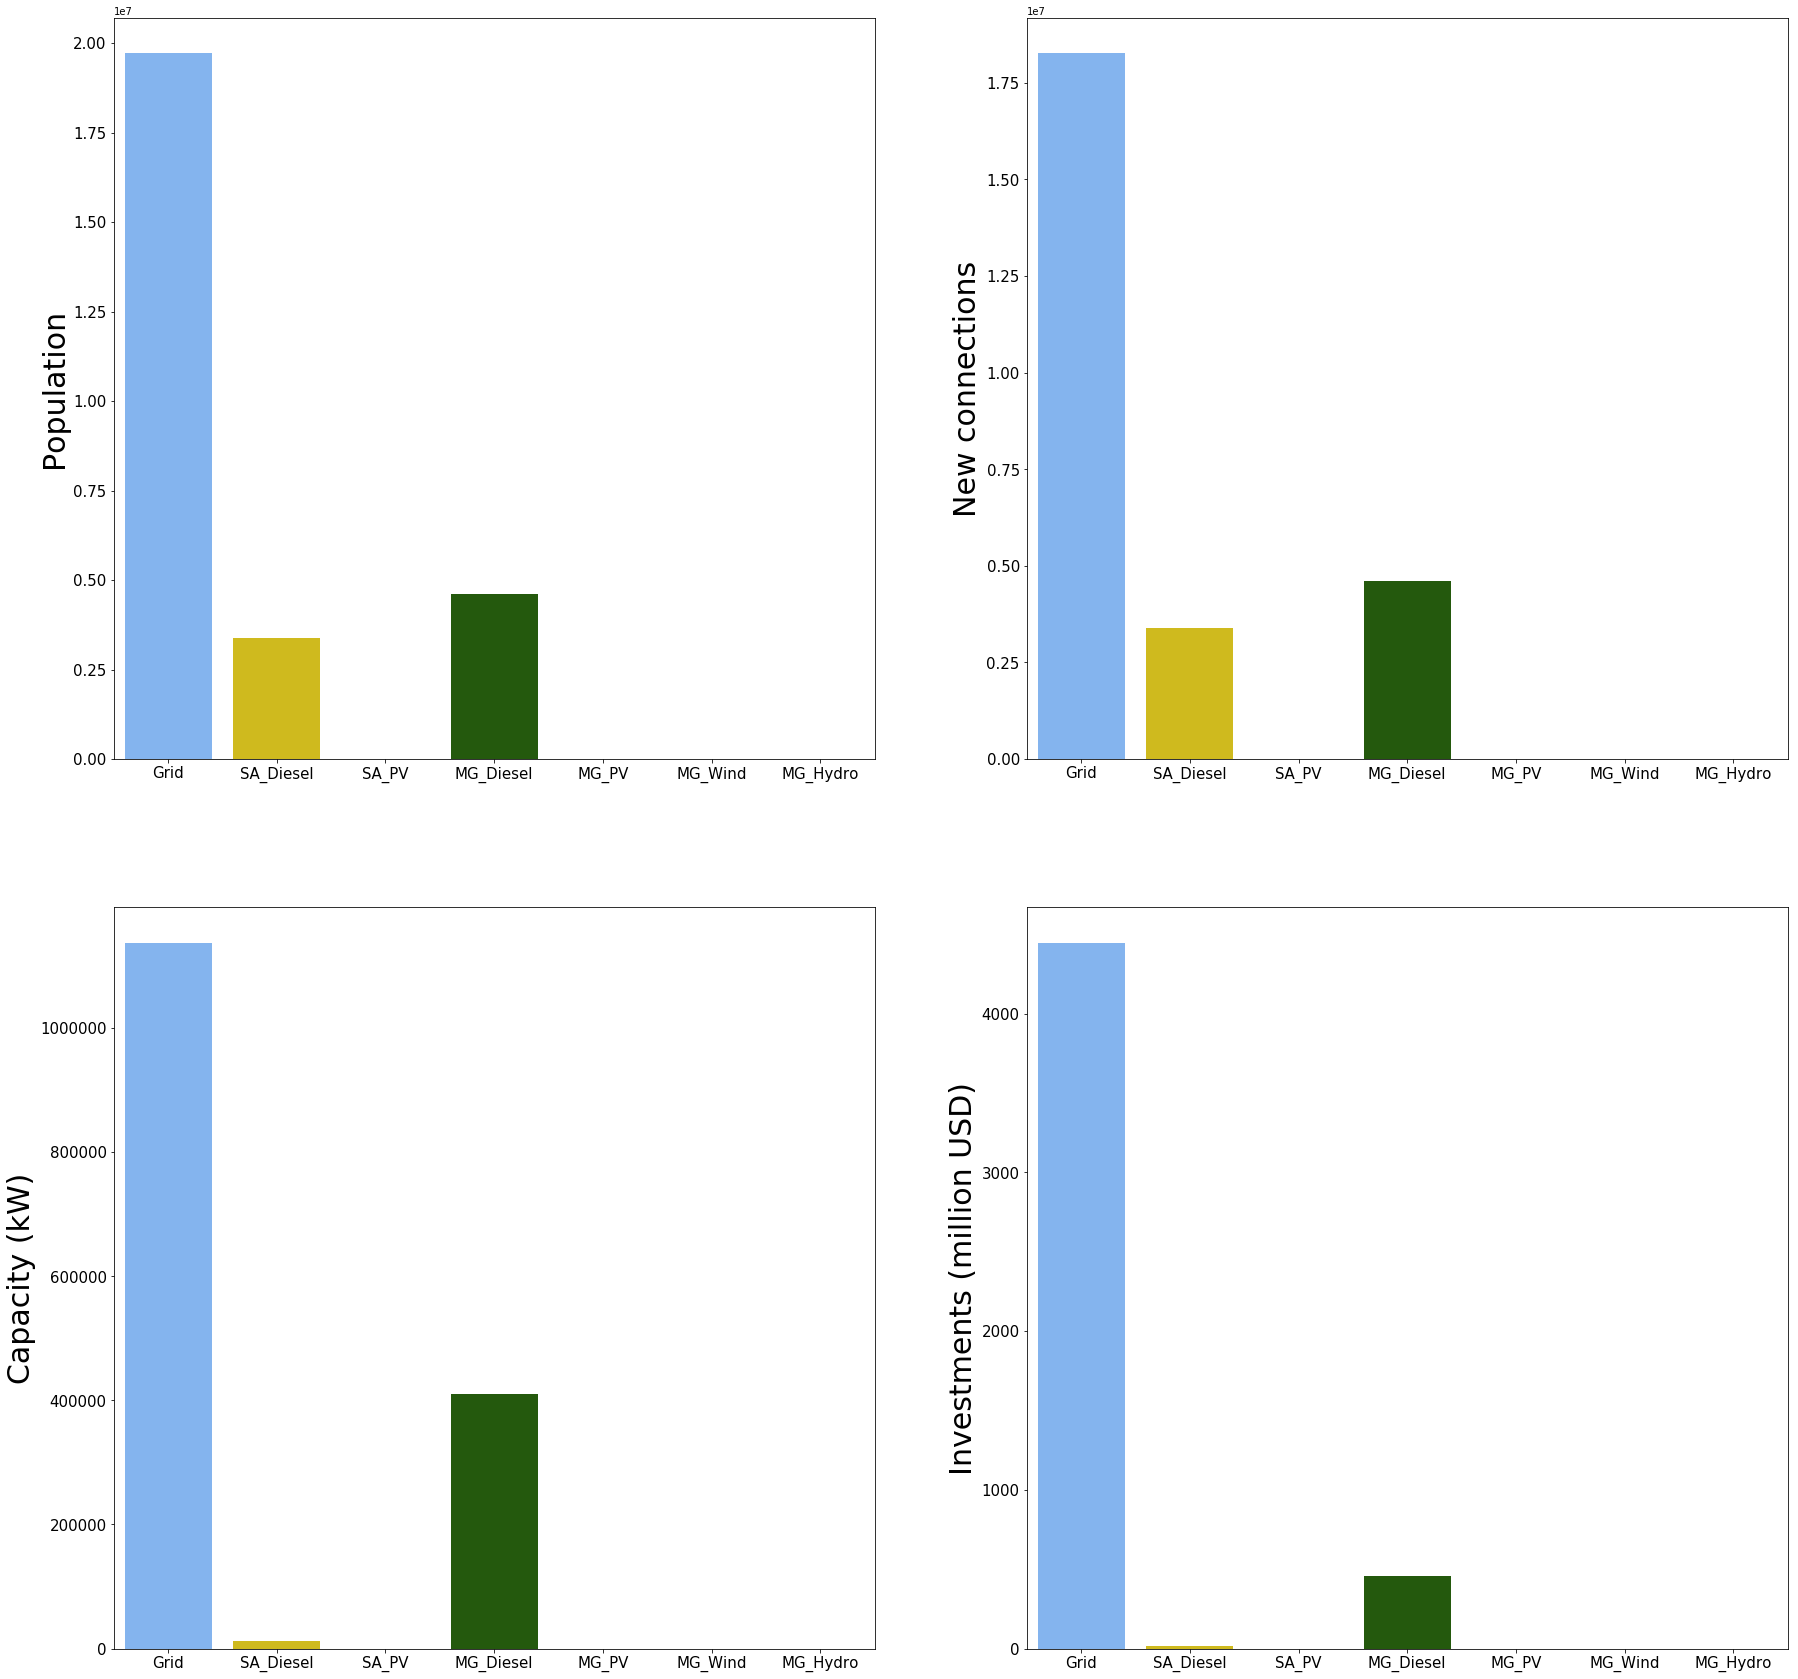

In [24]:
summary_plot=summary_table.drop(labels='Total',axis=0)
fig_size = [30, 30]
font_size = 15
plt.rcParams["figure.figsize"] = fig_size
f, axarr = plt.subplots(2, 2)
fig_size = [30, 30]
font_size = 15
plt.rcParams["figure.figsize"] = fig_size

sns.barplot(x=summary_plot.index.tolist(), y=columns[0], data=summary_plot, ax=axarr[0, 0], palette=colors)
axarr[0, 0].set_ylabel(columns[0], fontsize=2*font_size)
axarr[0, 0].tick_params(labelsize=font_size)
sns.barplot(x=summary_plot.index.tolist(), y=columns[1], data=summary_plot, ax=axarr[0, 1], palette=colors)
axarr[0, 1].set_ylabel(columns[1], fontsize=2*font_size)
axarr[0, 1].tick_params(labelsize=font_size)
sns.barplot(x=summary_plot.index.tolist(), y=columns[2], data=summary_plot, ax=axarr[1, 0], palette=colors)
axarr[1, 0].set_ylabel(columns[2], fontsize=2*font_size)
axarr[1, 0].tick_params(labelsize=font_size)
sns.barplot(x=summary_plot.index.tolist(), y=columns[3], data=summary_plot, ax=axarr[1, 1], palette=colors)
axarr[1, 1].set_ylabel(columns[3], fontsize=2*font_size)
axarr[1, 1].tick_params(labelsize=font_size)

## Mapping of electrification results

This code generates two maps:
 - one showing the spread of technologies
 - one showing the cost of electricity at each point
 
They can be accessed using the links below.

In [25]:
x_ave = o.df[SET_X_DEG].mean()
y_ave = o.df[SET_Y_DEG].mean()
lcoe_ave = o.df[SET_MIN_OVERALL_LCOE].median()

map_tech = folium.Map(location=[y_ave,x_ave], zoom_start=6)
map_lcoe = folium.Map(location=[y_ave,x_ave], zoom_start=6)

for index, row in o.df.iterrows():
    tech_color = techs_colors[(row[SET_MIN_OVERALL])]
    folium.CircleMarker([row[SET_Y_DEG], row[SET_X_DEG]],
                        radius=5000,#cell_size*300*(row['LCOE']/lcoe_ave)**2,
                        #popup='LCOE: {0:.3f} USD/kWh'.format(row['LCOE']),
                        color=tech_color,
                        fill_color=tech_color,
                       ).add_to(map_tech)


lcoe_colors = {0.1: '#edf8fb',0.2: '#ccece6',0.3: '#99d8c9',0.4: '#66c2a4',0.5: '#2ca25f',0.6: '#006d2c'}
for index, row in o.df.iterrows():
    lcoe = row[SET_MIN_OVERALL_LCOE]
    if lcoe > 0.6: lcoe = 0.6
    lcoe_color = lcoe_colors[ceil(lcoe*10)/10]
    folium.CircleMarker([row[SET_Y_DEG], row[SET_X_DEG]],
                        radius=5000,#cell_size*300*(row['LCOE']/lcoe_ave)**2,
                        #popup='LCOE: {0:.3f} USD/kWh'.format(row['LCOE']),
                        color=lcoe_color,
                        fill_color=lcoe_color,
                       ).add_to(map_lcoe)
    
grid_lines = []
for item in json.load(open('grid_planned.json'))['features']:
    grid_lines.append(item['geometry']['paths'][0])
for item in json.load(open('grid_existing.json'))['features']:
    grid_lines.append(item['geometry']['paths'][0])
    
for line in grid_lines:
    folium.PolyLine(line,
                    color='#656464',
                    weight=2.5,
                    opacity=0.9,
                    latlon=False).add_to(map_tech)
    folium.PolyLine(line,
                    color='#656464',
                    weight=2.5,
                    opacity=0.9,
                    latlon=False).add_to(map_lcoe)

try:
    os.makedirs('maps')
except FileExistsError:
    pass

map_tech_output = 'maps/map_{}{}_tech.html'.format(country, energy_per_hh_urban)
map_tech.save(map_tech_output)
map_lcoe_output = 'maps/map_{}{}_lcoe.html'.format(country, energy_per_hh_urban)
map_lcoe.save(map_lcoe_output)

display(Markdown('<a href="{}" target="_blank">Map of technology split</a>'.format(map_tech_output)))
display(Markdown('Colour coding for technology split:'))
display(HTML('<font color="{}">&bull;Grid</font>&nbsp;&nbsp;&nbsp;<font color="{}">&bull;SA Diesel</font>&nbsp;&nbsp;&nbsp;\
             <font color="{}">&bull;SA PV</font>&nbsp;&nbsp;&nbsp;<font color="{}">&bull;MG Diesel</font>&nbsp;&nbsp;&nbsp;\
             <font color="{}">&bull;MG PV</font>&nbsp;&nbsp;&nbsp;<font color="{}">&bull;Wind</font>&nbsp;&nbsp;&nbsp;\
             <font color="{}">&bull;Hydro</font>'.format(techs_colors[SET_LCOE_GRID], techs_colors[SET_LCOE_SA_DIESEL],
                                                         techs_colors[SET_LCOE_SA_PV], techs_colors[SET_LCOE_MG_DIESEL],
                                                         techs_colors[SET_LCOE_MG_PV], techs_colors[SET_LCOE_MG_WIND],
                                                         techs_colors[SET_LCOE_MG_HYDRO])))

display(Markdown('<a href="{}" target="_blank">Map of electricity cost</a>'.format(map_lcoe_output)))
display(Markdown('Colour coding for LCOE, in USD/kWh'))
cm.LinearColormap(['#edf8fb','#ccece6','#99d8c9','#66c2a4','#2ca25f','#006d2c'],
                  index=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6], vmin=0, vmax=0.6)

ValueError: ['latlon'] are not valid options, expected ('bubbling_mouse_events', 'color', 'dash_array', 'dash_offset', 'fill', 'fill_color', 'fill_opacity', 'fill_rule', 'line_cap', 'line_join', 'opacity', 'stroke', 'weight')

In [27]:
try:
    os.makedirs('csv_out')
except FileExistsError:
    pass

o.df.to_csv('csv_out/{}{}.csv'.format(country, energy_per_hh_urban), index=False)